# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tqdm
import random

from sklearn.metrics import confusion_matrix,accuracy_score, multilabel_confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# -------------------------------------------------------------
# Question 2 : Scene Recognition (BoVW)
# -------------------------------------------------------------

In this implementation of the BoVW classifier, the task is to classify an image into one of the 8 classes/categories of the SUN dataset. 

The idea of BoVW works by considering image patches (dense features) and their feature vectors are extracted from the image into a bag. 

Broadly, this image classification technique has three steps:

1. Feature Extraction – Determination of Image features of a given label.
2. Vocabulary creation – Construction of visual vocabulary by clustering, followed by frequency analysis via histograms.
3. Classification – Classification of images based on vocabulary generated using SVM.

## Load & Prepare Dataset

In [2]:
dataset_path = "../dataset/SUN_data/"

In [3]:
def get_images_and_classes(path):
    
    all_classes = {}
    train_data = []
        
    for index, folder in tqdm.tqdm(enumerate(sorted(glob.glob(path+"*")))):

        class_name = folder.rsplit("/", 1)[1]
        all_classes[index] = class_name
        
        for file in sorted(glob.glob(folder+"/*")):
            
            im = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
            #norm_img = np.zeros(im.shape)
            #im = cv2.normalize(im,  norm_img, 0, 255, cv2.NORM_MINMAX)
            im = cv2.resize(im, (150,150), interpolation = cv2.INTER_AREA)
            train_data.append([im, int(index)])
    
    train_data = np.asarray(train_data)    
    return train_data, all_classes

In [4]:
train_dataset, train_classes = get_images_and_classes(dataset_path+"train/")

8it [00:02,  3.65it/s]


In [5]:
test_dataset, test_classes = get_images_and_classes(dataset_path+"test/")

8it [00:00, 13.20it/s]


In [6]:
print(train_dataset.shape)
print(train_classes)

print(test_dataset.shape)
print(test_classes)

(640, 2)
{0: 'aquarium', 1: 'desert', 2: 'highway', 3: 'kitchen', 4: 'laundromat', 5: 'park', 6: 'waterfall', 7: 'windmill'}
(160, 2)
{0: 'aquarium', 1: 'desert', 2: 'highway', 3: 'kitchen', 4: 'laundromat', 5: 'park', 6: 'waterfall', 7: 'windmill'}


In [7]:
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)

Text(0.5, 1.0, 'Test Image - Cat:1')

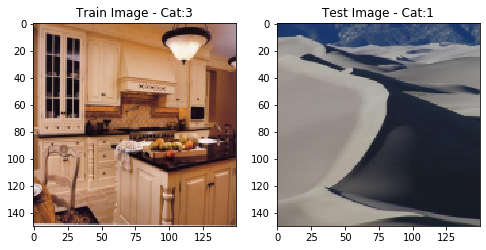

In [8]:
fig, ax = plt.subplots(1,2, figsize = (8,8))

ax[0].imshow(train_dataset[1][0])
ax[0].set_title("Train Image - Cat:" + str(train_dataset[1][1]))

ax[1].imshow(test_dataset[1][0])
ax[1].set_title("Test Image - Cat:" + str(test_dataset[1][1]))

## STEP 1 : Feature Extraction

The first step of the pipeline is to extract the features of the train images. This is done by feature detection followed by description wherein first all the keypoints are identified via the **dense sift** method and then their corresponding vector representations are obtained. 

Keypoints are the unique points in an image that can be understood without ambiguity. The keypoints have the ability to remain valid even if the image is rotated, shrunk, or expanded, its keypoints will always be the same. The main task of a keypoint descriptor is to describe an interesting patch(keypoint)in an image. This allows to select unique patches that can be used for ***feature clustering.*** 

Feature representation methods deal with how to represent the patches as numerical vectors. These vectors are called feature descriptors.A good descriptor should have the ability to handle the intensity, rotation, scale and affine variations to some extent.

The dense sift method is best suited for this, and enables us to obtain rich descriptors for the image.

In [9]:
def compute_dense_descriptors(images, stride):
    
    sift = cv2.SIFT_create()
    im_desc = []
    all_desc = []
    
    for img in tqdm.tqdm(images):
        keypoints = []
        h,w = img.shape[0], img.shape[1]

        for i in range(0, h, stride):
            for j in range(0, w, stride):
                keypoints.append(cv2.KeyPoint(i,j,stride))

        k, desc = sift.compute(img, keypoints)
        im_desc.append([img, desc])
        all_desc.append(desc.T)
    
    all_desc = np.concatenate( all_desc, axis=1 ).astype(float).T    
    return im_desc, all_desc
    

In [10]:
def compute_descriptors(images):
    
    #orb=cv2.ORB_create()
    sift = cv2.SIFT_create()
    
    im_desc = []
    all_desc = []
    
    for im in tqdm.tqdm(images):

        kp, desc = sift.detectAndCompute(im, None)
        im_desc.append([im, desc])
        
        all_desc.append(desc.T)    
    
    #dimensions (num_features, featurevec_size)
    all_desc = np.concatenate( all_desc, axis=1 ).astype(float).T    
    
    return im_desc, all_desc

In [11]:
im_desc_d, all_desc_d = compute_dense_descriptors(train_dataset[:,0], 8)

100%|██████████| 640/640 [00:04<00:00, 137.86it/s]


In [12]:
im_desc, all_desc = compute_descriptors(train_dataset[:,0])

100%|██████████| 640/640 [00:04<00:00, 130.48it/s]


In [13]:
print(len(im_desc[3][1])) #num of features for a particular image
print(all_desc.shape)     #total features/words x dimension of words
# plt.imshow(im_desc[3][0])

print(len(im_desc_d[3][1])) #num of features for a particular image
print(all_desc_d.shape)     #total features/words x dimension of words
# plt.imshow(im_desc[3][0])

115
(101942, 128)
361
(231040, 128)


## Step 2 : Vocabulary Construction / Clustering

Once all the different descriptors (feature vectors) are obtained for all the train images, these bunch of descriptors are then clustered usign the ***K-Means*** clustering algorithm. This is done with the intention to create a visual vocabulary, with the help of which the classification task can be performed. To perform the K-means algorithm given a particular *k* the steps are : 

1. Select initial centroids at random.
2. Assign each object to the cluster with the nearest centroid.
3. Compute each centroid as the mean of the objects assigned to it.
4. Repeat steps 2 and 3 until no change.

The visual vocabulary is used for quantizing features. Quantization of features here, means that the feature vector maps it to the index of the nearest word in the vocabulary. This enables us to understand the test images with respect to the *vocabulary* of the train images and their keypoints or feature descriptors.

In [14]:
CLUSTERS = 500

In [15]:
def cluster_words(all_descriptors):
    
    print("Clustering into ", CLUSTERS, "clusters")
    k = CLUSTERS
    
    batch_size = len(train_classes) * 3
    cluster = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=0).fit(all_descriptors)
    
    return cluster


def get_histogram(im_desc, clusterer, norm, tfidf):
    
    kmeans.verbose = False

    histogram = []
    print("Creating Histogram ...")
    for _, desc in tqdm.tqdm(im_desc):
        
        ind_histogram = np.zeros(CLUSTERS)
        descs = len(desc)
        
        for d in desc:
            idx = clusterer.predict([d])
            ind_histogram[idx] += 1
        
        if norm :
            ind_histogram = (ind_histogram) / np.sum(ind_histogram)
        histogram.append(ind_histogram)
    

    histogram = np.asarray(histogram)
    
    if tfidf:
        print("Reweighting TFIDF ...")
        histogram = tfidf_reweight(histogram)
      
        
    return histogram

In [16]:
def tfidf_reweight(hist):
    
    rewt_hist = np.zeros(hist.shape)
    
    for i in range(len(hist)):
        for j in range(len(hist[i])):
            
            #frequency of occurence of the word
            #num_words = len(np.where(hist[i, :] >0)[0])
            num_words = np.sum(hist[i, :])
            tf = hist[i][j]/num_words  
                        
            #inverse doc frequency
            N = len(hist)
            n = len(np.where( hist[:,j] > 0 )[0])
            idf =  np.log(N/(1+n))
            
            tfidf = tf*idf            
            rewt_hist[i][j] = tfidf
            
            
    return rewt_hist

In [17]:
clusterer = cluster_words(all_desc)

Clustering into  500 clusters


In [18]:
im_features_unnorm = get_histogram(im_desc, clusterer, 0, 0)

  0%|          | 0/640 [00:00<?, ?it/s]

Creating Histogram ...


100%|██████████| 640/640 [00:51<00:00, 12.37it/s]


In [19]:
im_features_norm = get_histogram(im_desc, clusterer, 1, 0)

  0%|          | 1/640 [00:00<01:05,  9.82it/s]

Creating Histogram ...


100%|██████████| 640/640 [00:45<00:00, 14.13it/s]


In [20]:
print(im_features_norm.shape)
print(im_features_unnorm.shape)

(640, 500)
(640, 500)


In [21]:
tfidf_features = get_histogram(im_desc, clusterer, 0,1)

  0%|          | 2/640 [00:00<00:58, 10.82it/s]

Creating Histogram ...


100%|██████████| 640/640 [00:55<00:00, 11.51it/s]


Reweighting TFIDF ...


In [22]:
print(tfidf_features.shape)

(640, 500)


In [23]:
# print(im_features_unnorm[0])
# print(sum(im_features_unnorm[0,:]))

## Step 3 : Classification of Images

The classification of images is done by constructing their respective histograms and freuqncies of occurences of the different visual words in the vocabulary. In order to train a **Linear Classifier** to be able to learn and understand this vocabulary one must translate the descriptors of each image in the training data to its **cluster centroid** that is convert each descriptor of an image to its corresponding vocabulary word. 

By doing so, a histogram is created for every image in the training data, where the bins correspond to the visual words, and the count of every bin corresponds to the number of times the corresponding visual word matches a 

This histogram can subsequently be used to train a Linear classifier with a *one-versus-rest strategy*.

### Creating the histograms:

While creating the histograms of the feature descriptors and the visual words, there could exist disparities that can skew the histogram and the training data. There exist a couple of methods to overcome this and fix the distribution : 

* Normalisation : Here the histogram counts for the visual words of a given image are simply divided by the total number of visual words (all not just unique) in the image. This prevents the image size does from dramatically changing the bag of visual words magnitude.

* TF-IDF : The term-frequency, inverse document frequency method is used to re-weight the histograms to enhance the importance of discriminative features and downweigh the uninformative features that occur in a lot of images. This is analogous to the words "the", "an", "a" in the tf-idf for documents. 



In [24]:
def build_classifier(im_features, reg=1):
    
    scaler = StandardScaler().fit(im_features)
    im_features_scaled = scaler.transform(im_features)
    
    #clf = LinearSVC(max_iter=50000, multi_class = "ovr", C=1) #one vs all and lambda reg = c
    clf = LinearSVC(max_iter=80000, multi_class = "ovr", C=reg) #one vs all and lambda reg = c
    clf.fit(im_features_scaled, train_dataset[:,1].astype(int))
    
    clf2 = OneVsRestClassifier(SVC()).fit(im_features_scaled, train_dataset[:,1].astype(int))
    
    return scaler, clf, clf2
    

In [25]:
def classify_images(images, classifier, scaler, norm, tfidf):
    
    im_des, all_descriptor = compute_descriptors(images)
    image_features = get_histogram(im_des, clusterer, norm, tfidf)
        
    image_features = scaler.transform(image_features)
    predicted_classes = classifier.predict(image_features)
    
    return predicted_classes

In [26]:
def get_accuracy(true, pred):
    
    corr = 0
    for t, p in zip(true, pred):
        if t == p:
            corr += 1
    
    return corr/len(true)

# Results and Experiments

## Unnormalized Features

In [27]:
scaler_unnorm1, clf1_unnorm1, clf2_unnorm1 = build_classifier(im_features_unnorm, 0.0001)
scaler_unnorm2, clf1_unnorm2, clf2_unnorm2 = build_classifier(im_features_unnorm, 0.001)
scaler_unnorm3, clf1_unnorm3, clf2_unnorm3 = build_classifier(im_features_unnorm, 0.01)

In [28]:
pred_test_classes_unnorm1 = classify_images(test_dataset[:,0], clf1_unnorm1, scaler_unnorm1, 0, 0)
pred_test_classes_unnorm2 = classify_images(test_dataset[:,0], clf1_unnorm2, scaler_unnorm2, 0, 0)
pred_test_classes_unnorm3 = classify_images(test_dataset[:,0], clf1_unnorm3, scaler_unnorm3, 0, 0)

  1%|▏         | 2/160 [00:00<00:08, 18.66it/s]

Creating Histogram ...


  1%|          | 1/160 [00:00<00:21,  7.24it/s]

Creating Histogram ...


  1%|          | 1/160 [00:00<00:20,  7.60it/s]

Creating Histogram ...


100%|██████████| 160/160 [00:14<00:00, 10.96it/s]


In [29]:
acc_unnorm1 = get_accuracy(test_dataset[:,1], pred_test_classes_unnorm1)
acc_unnorm2 = get_accuracy(test_dataset[:,1], pred_test_classes_unnorm2)
acc_unnorm3 = get_accuracy(test_dataset[:,1], pred_test_classes_unnorm3)
print("Results :")
print("--------------------------")
print("Accuracy with C = 0.0001 ", acc_unnorm1)
print("Accuracy with C = 0.001 ", acc_unnorm2)
print("Accuracy with C = 0.01 ", acc_unnorm3)
print("--------------------------")

Results :
--------------------------
Accuracy with C = 0.0001  0.44375
Accuracy with C = 0.001  0.4625
Accuracy with C = 0.01  0.375
--------------------------


## Normalised features

In [30]:
scaler_norm1, clf1_norm1, clf2_norm1 = build_classifier(im_features_norm, 0.0001)
scaler_norm2, clf1_norm2, clf2_norm2 = build_classifier(im_features_norm, 0.001)
scaler_norm3, clf1_norm3, clf2_norm3 = build_classifier(im_features_norm, 0.01)

In [31]:
pred_test_classes_norm1 = classify_images(test_dataset[:,0], clf1_norm1, scaler_norm1, 1, 0)
pred_test_classes_norm2 = classify_images(test_dataset[:,0], clf1_norm2, scaler_norm2, 1, 0)
pred_test_classes_norm3 = classify_images(test_dataset[:,0], clf1_norm3, scaler_norm3, 1, 0)

  0%|          | 0/160 [00:00<?, ?it/s]

Creating Histogram ...


  1%|          | 1/160 [00:00<00:18,  8.78it/s]

Creating Histogram ...


  1%|          | 1/160 [00:00<00:19,  8.29it/s]

Creating Histogram ...


100%|██████████| 160/160 [00:12<00:00, 13.03it/s]


In [32]:
acc_norm1 = get_accuracy(test_dataset[:,1], pred_test_classes_norm1)
acc_norm2 = get_accuracy(test_dataset[:,1], pred_test_classes_norm2)
acc_norm3 = get_accuracy(test_dataset[:,1], pred_test_classes_norm3)

print("Results :")
print("--------------------------")
print("Accuracy with C = 0.0001 ", acc_norm1)
print("Accuracy with C = 0.001 ", acc_norm2)
print("Accuracy with C = 0.01 ", acc_norm3)
print("--------------------------")

Results :
--------------------------
Accuracy with C = 0.0001  0.46875
Accuracy with C = 0.001  0.4125
Accuracy with C = 0.01  0.3625
--------------------------


**Observations :**

After performing classification we see that with normalization, the accuracy of classification increases. This is expected as the normalization of the histogram weighs out the criteria of the image size and consdiders all the same images

Further, on tuning the parameter **gamma** the regularisation term, we observe that with a decrease in the value of **gamma** the accuracy of the linear classifier further increases. This is because, the strength of the regularization is **inversely proportional** to gamma.


| Gamma   |      Unnormalised Acc      |  Normalised Acc |
|----------|:-------------:|------:|
| **0.0001** |  0.44375 | **0.46875** |
| 0.001 |    0.4625   |   0.4125 |
| 0.01 | 0.375 |    0.3625 |

## Confusion Matrices

The confusion matrices for the two types of features - normalised and unnormalised features have been plotted below

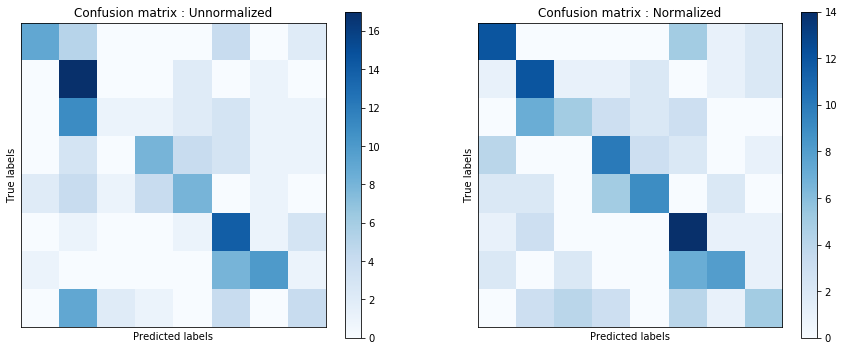

In [33]:
cm1 = sklearn.metrics.confusion_matrix(test_dataset[:,1].tolist(), pred_test_classes_unnorm1.tolist())
cm2 = sklearn.metrics.confusion_matrix(test_dataset[:,1].tolist(), pred_test_classes_norm1.tolist())

fig, ax = plt.subplots(1,2, figsize = (15,6))

p0 = ax[0].imshow(cm1, cmap=plt.cm.Blues)
ax[0].set_xlabel("Predicted labels")
ax[0].set_ylabel("True labels")
ax[0].set_xticks([], [])
ax[0].set_yticks([], [])
ax[0].set_title('Confusion matrix : Unnormalized')

p1 = ax[1].imshow(cm2, cmap=plt.cm.Blues)
ax[1].set_xlabel("Predicted labels")
ax[1].set_ylabel("True labels")
ax[1].set_xticks([], [])
ax[1].set_yticks([], [])
ax[1].set_title('Confusion matrix : Normalized')

fig.colorbar(p0, ax=ax[0])
fig.colorbar(p1, ax=ax[1])

## Correct and Incorrect Classifications

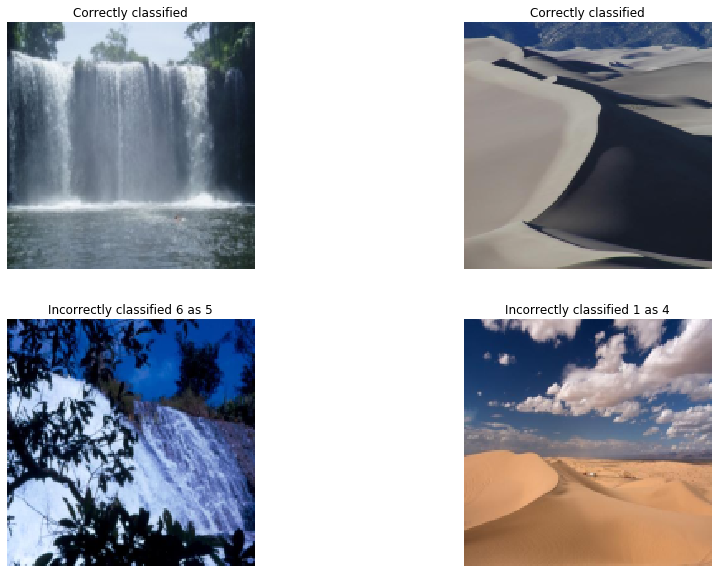

In [46]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
tc = 0 
fc = 0
i=0

for true, pred in zip(test_dataset[:,1], pred_test_classes_norm1):
    
    if true == pred and tc < 2:
        ax[0][tc].imshow(test_dataset[i][0])
        ax[0][tc].set_title("Correctly classified")
        ax[0][tc].axis('off')
        tc += 1
        
    elif true != pred and fc < 2:
        ax[1][fc].imshow(test_dataset[i][0])
        ax[1][fc].set_title("Incorrectly classified "+str(test_dataset[i][1])+" as "+str(pred_test_classes_norm1[i]))
        ax[1][fc].axis('off')
        fc += 1
        
    i+=1
        

## Implementing Tf-IDf with normalisation

In [35]:
scaler_tf1, clf1_tf1, clf2_tf1 = build_classifier(tfidf_features, 0.0001)
scaler_tf2, clf1_tf2, clf2_tf2 = build_classifier(tfidf_features, 0.001)
scaler_tf3, clf1_tf3, clf2_tf3 = build_classifier(tfidf_features, 0.01)

In [36]:
pred_test_classes_tfidf1 = classify_images(test_dataset[:,0], clf1_tf1, scaler_tf3, 0, 1)
pred_test_classes_tfidf2 = classify_images(test_dataset[:,0], clf1_tf2, scaler_tf2, 0, 1)
pred_test_classes_tfidf3 = classify_images(test_dataset[:,0], clf1_tf3, scaler_tf1, 0, 1)

  0%|          | 0/160 [00:00<?, ?it/s]

Creating Histogram ...


100%|██████████| 160/160 [00:11<00:00, 13.35it/s]


Reweighting TFIDF ...


  1%|▏         | 2/160 [00:00<00:08, 19.19it/s]

Creating Histogram ...


100%|██████████| 160/160 [00:12<00:00, 13.24it/s]


Reweighting TFIDF ...


  1%|          | 1/160 [00:00<00:17,  8.92it/s]

Creating Histogram ...


100%|██████████| 160/160 [00:13<00:00, 11.73it/s]


Reweighting TFIDF ...


In [37]:
acc_tfidf1 = get_accuracy(test_dataset[:,1], pred_test_classes_tfidf1)
acc_tfidf2 = get_accuracy(test_dataset[:,1], pred_test_classes_tfidf2)
acc_tfidf3 = get_accuracy(test_dataset[:,1], pred_test_classes_tfidf3)

In [38]:
print("Results :")
print("--------------------------")
print("Accuracy with C = 0.0001 ", acc_tfidf1)
print("Accuracy with C = 0.001 ", acc_tfidf2)
print("Accuracy with C = 0.01 ", acc_tfidf3)
print("--------------------------")

Results :
--------------------------
Accuracy with C = 0.0001  0.4625
Accuracy with C = 0.001  0.38125
Accuracy with C = 0.01  0.35
--------------------------
